In [1]:
!pip list

Package                       Version            
----------------------------- -------------------
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
Babel                         2.9.1              
backcall                      0.2.0              


In [2]:
import os.path
import tensorflow as tf
import pickle as pkl
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from matplotlib import pyplot as plt

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
no_classes = 10
img_width, img_height, img_num_channels = 32, 32, 3

In [5]:
(input_train, target_train), (input_test, target_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [7]:
modelseq = Sequential()
modelseq.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
modelseq.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Flatten())
modelseq.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelseq.add(Dropout(0.2))
modelseq.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
modelseq.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize layers
print(modelseq.summary())
# plot graph
#plot_model(modelseq, to_file='modelseq.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
# first model
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

# second model
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(10, activation='softmax'))

# third model
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))
model4.add(Dense(10, activation='softmax'))


opt = keras.optimizers.Adam(learning_rate=0.001)
opt2 = keras.optimizers.Adam(learning_rate=0.01)
opt3 = SGD(lr=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer=opt2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer=opt3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# summarize layers
print(model2.summary())
print(model3.summary())
print(model4.summary())
# plot graph
#plot_model(model2, to_file='model2.png')
#plot_model(model3, to_file='model3.png')
#plot_model(model4, to_file='model4.png')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
# Fit data to model
history = modelseq.fit(input_train, target_train,
            batch_size=64,
            epochs=25,
            verbose=1,
            validation_split=0.2)

Epoch 1/25
625/625 [==============================] - 60s 24ms/step - loss: 2.2388 - accuracy: 0.1615 - val_loss: 1.8412 - val_accuracy: 0.3479
Epoch 2/25
625/625 [==============================] - 14s 22ms/step - loss: 1.8080 - accuracy: 0.3409 - val_loss: 1.6170 - val_accuracy: 0.4159
Epoch 3/25
625/625 [==============================] - 14s 22ms/step - loss: 1.6376 - accuracy: 0.3977 - val_loss: 1.5113 - val_accuracy: 0.4493
Epoch 4/25
625/625 [==============================] - 14s 22ms/step - loss: 1.5358 - accuracy: 0.4369 - val_loss: 1.4170 - val_accuracy: 0.4888
Epoch 5/25
625/625 [==============================] - 14s 22ms/step - loss: 1.4576 - accuracy: 0.4641 - val_loss: 1.3434 - val_accuracy: 0.5261
Epoch 6/25
625/625 [==============================] - 14s 22ms/step - loss: 1.3825 - accuracy: 0.4991 - val_loss: 1.2988 - val_accuracy: 0.5389
Epoch 7/25
625/625 [==============================] - 14s 23ms/step - loss: 1.3453 - accuracy: 0.5156 - val_loss: 1.2529 - val_accuracy:

In [12]:
history2 = model2.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 20s 24ms/step - loss: 1.9112 - accuracy: 0.3297 - val_loss: 1.4504 - val_accuracy: 0.4897
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 1.3032 - accuracy: 0.5275 - val_loss: 1.0656 - val_accuracy: 0.6173
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 1.0474 - accuracy: 0.6307 - val_loss: 1.3571 - val_accuracy: 0.5630
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 0.9083 - accuracy: 0.6806 - val_loss: 0.7908 - val_accuracy: 0.7225
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 0.7974 - accuracy: 0.7183 - val_loss: 0.8174 - val_accuracy: 0.7174
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 0.7242 - accuracy: 0.7474 - val_loss: 0.7598 - val_accuracy: 0.7380
Epoch 7/10
625/625 [==============================] - 14s 23ms/step - loss: 0.6583 - accuracy: 0.7700 - val_loss: 0.6839 - val_accuracy:

In [13]:
history3 = model3.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 2.8915 - accuracy: 0.2501 - val_loss: 2.3617 - val_accuracy: 0.2553
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 1.6049 - accuracy: 0.4146 - val_loss: 1.3492 - val_accuracy: 0.5233
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 1.3615 - accuracy: 0.5122 - val_loss: 1.1694 - val_accuracy: 0.5956
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 1.2230 - accuracy: 0.5698 - val_loss: 1.4922 - val_accuracy: 0.5393
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 1.1391 - accuracy: 0.6004 - val_loss: 1.0672 - val_accuracy: 0.6252
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 1.0948 - accuracy: 0.6248 - val_loss: 1.1238 - val_accuracy: 0.6167
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 1.0640 - accuracy: 0.6338 - val_loss: 1.0980 - val_accuracy: 0.633

In [16]:
history4 = model4.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 30s 48ms/step - loss: 0.6828 - accuracy: 0.7558 - val_loss: 1.2347 - val_accuracy: 0.6365
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.5745 - accuracy: 0.7926 - val_loss: 1.1714 - val_accuracy: 0.6532
Epoch 3/10
625/625 [==============================] - 30s 48ms/step - loss: 0.4758 - accuracy: 0.8309 - val_loss: 1.1710 - val_accuracy: 0.6571
Epoch 4/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3985 - accuracy: 0.8564 - val_loss: 1.2281 - val_accuracy: 0.6555
Epoch 5/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3307 - accuracy: 0.8827 - val_loss: 1.2737 - val_accuracy: 0.6680
Epoch 6/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2806 - accuracy: 0.9025 - val_loss: 1.2782 - val_accuracy: 0.6768
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2395 - accuracy: 0.9164 - val_loss: 1.3446 - val_accuracy:

Test loss: 0.7617244124412537 / Test accuracy: 0.7319999933242798
Test loss: 0.6951228380203247 / Test accuracy: 0.7717000246047974
Test loss: 1.0024852752685547 / Test accuracy: 0.6553999781608582
Test loss: 1.5568920373916626 / Test accuracy: 0.6674000024795532


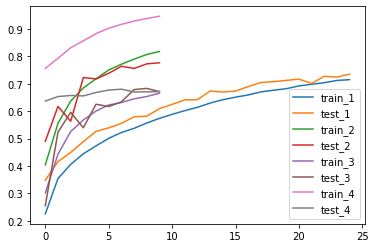

In [17]:
# Generate generalization metrics
score = modelseq.evaluate(input_test, target_test, verbose=0)
score2 = model2.evaluate(input_test, target_test, verbose=0)
score3 = model3.evaluate(input_test, target_test, verbose=0)
score4 = model4.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')
print(f'Test loss: {score3[0]} / Test accuracy: {score3[1]}')
print(f'Test loss: {score4[0]} / Test accuracy: {score4[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['accuracy'],label = 'train_1')
plt.plot(history.history['val_accuracy'],label = 'test_1')
plt.plot(history2.history['accuracy'],label = 'train_2')
plt.plot(history2.history['val_accuracy'],label = 'test_2')
plt.plot(history3.history['accuracy'],label = 'train_3')
plt.plot(history3.history['val_accuracy'],label = 'test_3')
plt.plot(history4.history['accuracy'],label = 'train_4')
plt.plot(history4.history['val_accuracy'],label = 'test_4')
plt.legend()
plt.show()


In [18]:
#print(input_test[1])
single = np.expand_dims(input_test[250], axis=0)
prediction1 = modelseq.predict(input_test)
prediction2 = model2.predict(input_test)
prediction3 = model3.predict(input_test)
prediction4 = model4.predict(input_test)

In [21]:
#sum
predictsum = prediction3+prediction4
#multiply with square of accuracy 
predictsum2 = score3[1]**2*prediction3+score4[1]**2*prediction4

predictsum3 = prediction1+prediction2+prediction3+prediction4
predictsum4 = score[1]**2*prediction1+score2[1]**2*prediction2+score3[1]**2*prediction3+score4[1]**2*prediction4


In [22]:
print(predictsum[2].sum())
print(target_test.shape)
print(np.mean(np.argmax(predictsum,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum2,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum3,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum4,axis=1)==np.squeeze(target_test)))

2.0
(10000, 1)
0.696
0.6944
0.77
0.7789
